### Unattended Luggage Detection

#### Load Modules

In [1]:
# LOAD MODULES
# Import Modules
import pickle
import os
import pickle
import math
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import random
import glob
import time
import tensorflow as tf
from sklearn.utils import shuffle
import csv
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import ndimage as ndi
from skimage.feature import blob_doh
from skimage.feature import peak_local_max
from skimage.morphology import watershed,disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops

print('Importing Modules')

Importing Modules


/home/avidbots/Documents/Machine-Learning/Codes/Models/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/avidbots/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/avidbots/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/avidbots/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io

#### Load Models

In [2]:
# LOAD MODEL
# Setup Paths
ModelPath='/home/avidbots/Documents/Machine-Learning/Codes/Models'

# Set Path to frozen detection graph. This is the Actual Model that is used for the Object Detection.
ModelName='mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
PathModel=os.path.join(ModelPath,'object_detection',ModelName,'frozen_inference_graph.pb')

# List of the Strings that is used to add correct Label for each Box.
PathLabel=os.path.join(ModelPath,'object_detection','data','mscoco_label_map.pbtxt')

In [3]:
# LOAD MODEL
# Set Number of Classes in Model
NumClasses=90

# Loading Label Map
LabelMap=label_map_util.load_labelmap(PathLabel)
Categories=label_map_util.convert_label_map_to_categories(LabelMap,
                                                          max_num_classes=NumClasses,
                                                          use_display_name=True)
CategoryIndex=label_map_util.create_category_index(Categories)

#### Object Detection

In [4]:
# OBJECT DETECTION
# Load a Frozen TF Model 
DetectionGraph=tf.Graph()
with DetectionGraph.as_default():
    OdGraphDef=tf.GraphDef()
    with tf.gfile.GFile(PathModel,'rb') as fid:
        SerializedGraph=fid.read()
        OdGraphDef.ParseFromString(SerializedGraph)
        tf.import_graph_def(OdGraphDef,name='')

In [5]:
# OBJECT DETECTION
# Write a Function to Convert Image into Numpy Array
def LoadImageNumpyArray(Image):
  (ImageWidth,ImageHeight)=Image.size
  return np.array(Image.getdata()).reshape((ImageHeight,ImageWidth,3)).astype(np.uint8)

In [6]:
# OBJECT DETECTION
# Set Paths to Test Images
PathTestImagesFolder='//home/avidbots/Documents/Machine-Learning/Codes/Object-Detection/Test-Images'
PathTestImages=[os.path.join(PathTestImagesFolder,'test{}.jpg'.format(i)) for i in range(6,8)]

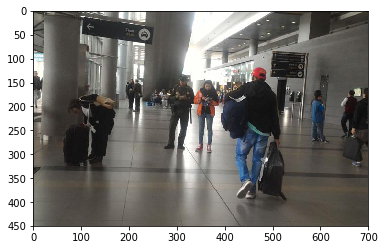

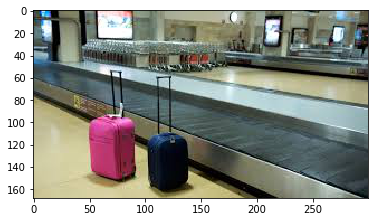

In [8]:
# OBJECT DETECTION
# Write a Function to Detect Objects
def DetectObjects(Image,Graph):
  with Graph.as_default():
    with tf.Session() as sess:
      Ops=tf.get_default_graph().get_operations()
      AllTensorNames={output.name for Op in Ops for output in Op.outputs}
      TensorDict={}
      for Key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        TensorName=Key+':0'
        if TensorName in AllTensorNames:
          TensorDict[Key]=tf.get_default_graph().get_tensor_by_name(TensorName)
      if 'detection_masks' in TensorDict:
        DetectionBoxes=tf.squeeze(TensorDict['detection_boxes'],[0])
        DetectionMasks=tf.squeeze(TensorDict['detection_masks'],[0])
        RealNumDetection=tf.cast(TensorDict['num_detections'][0],tf.int32)
        DetectionBoxes=tf.slice(DetectionBoxes, [0,0], [RealNumDetection,-1])
        DetectionMasks=tf.slice(DetectionMasks, [0,0,0], [RealNumDetection,-1,-1])
        DetectionMasksReframed=utils_ops.reframe_box_masks_to_image_masks(
            DetectionMasks,DetectionBoxes,Image.shape[0],Image.shape[1])
        DetectionMasksReframed=tf.cast(
            tf.greater(DetectionMasksReframed, 0.5), tf.uint8)
        TensorDict['detection_masks']=tf.expand_dims(
            DetectionMasksReframed,0)
      ImageTensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      OutputDict=sess.run(TensorDict,
                             feed_dict={ImageTensor:np.expand_dims(Image,0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      OutputDict['num_detections']=int(OutputDict['num_detections'][0])
      OutputDict['detection_classes']=OutputDict[
          'detection_classes'][0].astype(np.uint8)
      OutputDict['detection_boxes']=OutputDict['detection_boxes'][0]
      OutputDict['detection_scores']=OutputDict['detection_scores'][0]
      if 'detection_masks' in OutputDict:
        OutputDict['detection_masks']=OutputDict['detection_masks'][0]
  return OutputDict

In [9]:
# OBJECT DETECTION
# Configure
config=tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type='BFC'
config.gpu_options.per_process_gpu_memory_fraction=0.80

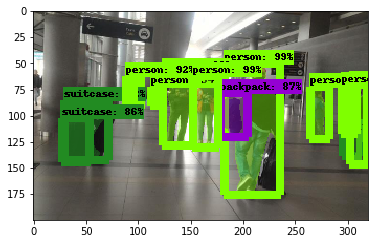

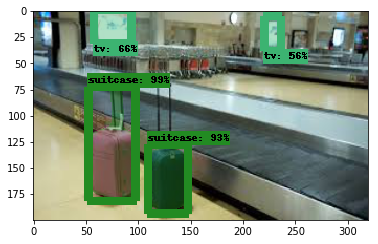

In [11]:
# OBJECT DETECTION
#Predict
for ImagePath in PathTestImages:
  ImageOrig=Image.open(ImagePath)
  ImageNP=LoadImageNumpyArray(ImageOrig)
  ImageNP=cv2.resize(ImageNP,(320,200))
  ImageNPExpanded=np.expand_dims(ImageNP, axis=0)
  OutputDict=DetectObjects(ImageNP, DetectionGraph)
  vis_util.visualize_boxes_and_labels_on_image_array(
      ImageNP,
      OutputDict['detection_boxes'],
      OutputDict['detection_classes'],
      OutputDict['detection_scores'],
      CategoryIndex,
      instance_masks=OutputDict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=(6,4))
  plt.imshow(ImageNP)